In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'videos-160:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1476638%2F3231177%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240128%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240128T021525Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D029b96ebfe10f331ac613a5f1775690ffd57530f7c869443018d5f49f4de45cd278142187890625011ffa523061b5b3130a3816c9a04064b3196ff5fbce34e4996d87c6bd5bd8c482d98ee5143b0cd426c42c11052c49d53915f51c500cf7a1ca54f1c1afb533cf2432794792f4734da36c7fcc7b467992708a922954a7e8adf005e488b9ab06026b88a521f344a1ac083797bfb9bdee650cb75a6349fe2a1346b2ba4483fd753bb332f38e98fe4f3c7a2976127a2a1da56d09dd437ab9e0e085c7d21bdb5bc7afb161dd5eb2b088240fbf08af06f32a8d6e18fd61805fa0585355e2f068a32ce31a959ccd9f931b028e19b5698f46e70e7fab55e3a62fe76e5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 699229620 bytes downloaded
Downloaded and uncompressed: videos-160
Data source import complete.


In [2]:
import os
import csv

import numpy as np
import pandas as pd

from scipy.io import loadmat

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/videos-160/GolfDB.pkl
/kaggle/input/videos-160/GolfDB.csv
/kaggle/input/videos-160/golfDB.mat
/kaggle/input/videos-160/videos_160/videos_160/73.mp4
/kaggle/input/videos-160/videos_160/videos_160/297.mp4
/kaggle/input/videos-160/videos_160/videos_160/885.mp4
/kaggle/input/videos-160/videos_160/videos_160/153.mp4
/kaggle/input/videos-160/videos_160/videos_160/784.mp4
/kaggle/input/videos-160/videos_160/videos_160/735.mp4
/kaggle/input/videos-160/videos_160/videos_160/1154.mp4
/kaggle/input/videos-160/videos_160/videos_160/300.mp4
/kaggle/input/videos-160/videos_160/videos_160/220.mp4
/kaggle/input/videos-160/videos_160/videos_160/3.mp4
/kaggle/input/videos-160/videos_160/videos_160/504.mp4
/kaggle/input/videos-160/videos_160/videos_160/242.mp4
/kaggle/input/videos-160/videos_160/videos_160/55.mp4
/kaggle/input/videos-160/videos_160/videos_160/708.mp4
/kaggle/input/videos-160/videos_160/videos_160/530.mp4
/kaggle/input/videos-160/videos_160/videos_160/112.mp4
/kaggle/input/v

In [3]:
import numpy as np
import pandas as pd
pd.options.display.width = None
pd.set_option("max_colwidth", None)
pd.options.display.max_rows = 999
import cv2
import pickle
import gzip
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import svm, metrics, datasets
from sklearn.utils import Bunch
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import  MinMaxScaler
from sklearn.svm import SVC
from skimage.io import imread
from skimage.transform import resize
import warnings
warnings.filterwarnings("ignore")
import skimage
import os
from skimage.feature import hog
from skimage import exposure
rseed = 42


In [4]:
def load_df(file_name):
    pd.options.display.width = None
    pd.options.display.max_rows = 999
    pd.set_option("max_colwidth", None)

    x = loadmat(file_name)
    l = list(x['golfDB'][0])
    d = dict()

    for idx, k in enumerate(l):
        d["{:3d}".format(idx)] = list(l[idx])

    df = pd.DataFrame(d).T
    df.columns = ["id", "youtube_id", "player", "sex", "club", "view", "slow", "events", "bbox", "split"]

    df['id'] = df['id'].apply(lambda x: x[0][0])
    df['youtube_id'] = df['youtube_id'].apply(lambda x: x[0])
    df['player'] = df['player'].apply(lambda x: x[0])
    df['sex'] = df['sex'].apply(lambda x: x[0])
    df['club'] = df['club'].apply(lambda x: x[0])
    df['view'] = df['view'].apply(lambda x: x[0])
    df['slow'] = df['slow'].apply(lambda x: x[0][0])
    df['events'] = df['events'].apply(lambda x: x[0])
    df['bbox'] = df['bbox'].apply(lambda x: x[0])
    df['split'] = df['split'].apply(lambda x: x[0][0])

    df = df.drop(columns=['split', 'youtube_id'])
    df.index = df.index.astype(int)
    df.to_csv('golfDB.csv')

    print("Number of annotations: {:3d}".format(len(df.id)))
    return df

In [5]:
def pyramid(image, scale=1.5, minSize=(30, 30)):
    yield image

    while True:
        w = int(image.shape[1] / scale)

        # image = imutils.resize(image, width=w)
        image = cv2.resize(image, width=w)

        # if the resized image does not meet the supplied minimum
        # size, then stop constructing the pyramid
        if image.shape[0] < minSize[1] or image.shape[1] < minSize[0]:
            break
        # yield the next image in the pyramid
        yield image

In [6]:
def sliding_window(image, step, window):
    # slide a window across the image
    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            # yield the current window
            yield (x, y, image[y: y + window[1], x: x + window[0]])

In [7]:
def detect_golfer(image):
    (winW, winH) = (90, 120)
    hog = cv2.HOGDescriptor()
    hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

    for resized in pyramid(image, scale=1.5):
        for (x, y, window) in sliding_window(resized, step=1, window=(winW, winH)):
            # if the window does not meet the desired window size, ignore it
            if window.shape[0] != winH or window.shape[1] != winW:
                continue

            window_gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
            rects, weights = hog.detectMultiScale(window_gray, winStride=(1, 1), padding=(10, 10), scale=1.01)

            if len(rects) > 0:
                for i, (x, y, w, h) in enumerate(rects):
                    cropped_frame = resized[y:y+winH, x:x + winW]

                if weights[i] > 0.3:
                    return True, cropped_frame
                else :
                    return False, image
            else:
                return False, image


In [8]:
def draw_bbox(id, df):
    video_path = "../input/videos-160/videos_160/videos_160/" + str(id) + ".mp4"
    video = cv2.VideoCapture(video_path)

    event_num, iterations = 1, 0
    events = df.events[id]

    x, y, w, h = df.bbox[id]
    x, y, w, h = int(x*160), int(y*160), int(w*160), int(h*160)
    label = ['Address', 'Toe-up', 'Mid-Backswing', 'Top', 'Mid-Downswing', 'Impact', 'Mid-Follow-Through', 'Finish']

    while True:
        ret, frame = video.read()

        if not ret:
            break
        if iterations == events[event_num] and event_num < 9:
            cv2.imwrite("Swing_events/" + label[event_num - 1] + "/" + str(id) + ".jpg", frame)
            event_num += 1
        iterations += 1

    video.release()
    return rows

In [9]:
df = load_df('./sample_data/golfDB.mat')
print(df.head(16))

Number of annotations: 1400
    id            player sex    club           view  slow  \
0    0        SANDRA GAL   f  driver  down-the-line     0   
1    1        SANDRA GAL   f  driver  down-the-line     1   
2    2     CHRIS DIMARCO   m  driver  down-the-line     0   
3    3     CHRIS DIMARCO   m  driver  down-the-line     1   
4    4  BROOKE HENDERSON   f  driver  down-the-line     0   
5    5  BROOKE HENDERSON   f  driver  down-the-line     1   
6    6       NICK WATNEY   m  driver  down-the-line     0   
7    7       NICK WATNEY   m  driver  down-the-line     1   
8    8      CRISTIE KERR   f  driver        face-on     0   
9    9      CRISTIE KERR   f  driver        face-on     1   
10  10    STEVE STRICKER   m  driver        face-on     0   
11  11    STEVE STRICKER   m  driver        face-on     1   
12  12      KYLE STANLEY   m  driver  down-the-line     0   
13  13      KYLE STANLEY   m  driver          other     1   
14  14       GREG NORMAN   m  driver        face-on     0

In [10]:
for index in df.index:
    i = 0
    events = df.events[index]
    scaled_events = []
    for event in events:
        if i == 0:
            scaled_events.append(0)
        else:
            scaled_events.append(event - events[0])
        i += 1
    df.events[index] = scaled_events

print(df.head(15))

    id            player sex    club           view  slow  \
0    0        SANDRA GAL   f  driver  down-the-line     0   
1    1        SANDRA GAL   f  driver  down-the-line     1   
2    2     CHRIS DIMARCO   m  driver  down-the-line     0   
3    3     CHRIS DIMARCO   m  driver  down-the-line     1   
4    4  BROOKE HENDERSON   f  driver  down-the-line     0   
5    5  BROOKE HENDERSON   f  driver  down-the-line     1   
6    6       NICK WATNEY   m  driver  down-the-line     0   
7    7       NICK WATNEY   m  driver  down-the-line     1   
8    8      CRISTIE KERR   f  driver        face-on     0   
9    9      CRISTIE KERR   f  driver        face-on     1   
10  10    STEVE STRICKER   m  driver        face-on     0   
11  11    STEVE STRICKER   m  driver        face-on     1   
12  12      KYLE STANLEY   m  driver  down-the-line     0   
13  13      KYLE STANLEY   m  driver          other     1   
14  14       GREG NORMAN   m  driver        face-on     0   

                       

In [11]:
 df.to_pickle("./sample_data/GolfDB.pkl")

In [12]:
import shutil
if os.path.exists("./Swing_events"):
    shutil.rmtree("./Swing_events")

In [13]:
os.makedirs('./Swing_events/Address')
os.makedirs('./Swing_events/Toe-up')
os.makedirs('./Swing_events/Mid-Backswing')
os.makedirs('./Swing_events/Top')
os.makedirs('./Swing_events/Mid-Downswing')
os.makedirs('./Swing_events/Impact')
os.makedirs('./Swing_events/Mid-Follow-Through')
os.makedirs('./Swing_events/Finish')

In [14]:
df = pd.read_pickle("./sample_data/GolfDB.pkl")

i = 0
rows = []
while i < 1400:
    if df.view[i] == "face-on": # toggle the view between down-the-line, face-on or other to evaluate the different views.
        draw_bbox(df.id[i], df)
    if (i % 100 == 0):
        print(i)
    i += 1

fields = ["index", "event", "view"]
filename = "object_detection_records.csv"

with open(filename, 'w') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(fields)
    csvwriter.writerows(rows)

csvfile.close()

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300


In [15]:
def load_image_files(container_path, dimension=(30, 30)):
    image_dir = Path(container_path)
    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]
    categories = [fo.name for fo in folders]

    descr = "Your own dataset"
    images = []
    flat_data = []
    target = []
    for i, direc in enumerate(folders):
        for file in direc.iterdir():
            img = skimage.io.imread(file)
            img_resized = resize(img, dimension, anti_aliasing=True, mode='reflect')
            flat_data.append(img_resized.flatten())
            images.append(img_resized)
            target.append(i)
    flat_data = np.array(flat_data)
    target = np.array(target)
    images = np.array(images)


    np.save('flat_dat.npy', flat_data)
    np.save('target.npy', target)
    np.save('target_names', categories)
    np.save('images.npy', images)
    np.save('descr.npy', descr)

    return Bunch(data=flat_data, target=target, target_names=categories, images=images, DESCR=descr)

In [16]:
swing_image_dataset = load_image_files("./Swing_events/")

In [17]:
swing_image_dataset.data.shape

(3688, 2700)

In [18]:
swing_image_dataset.target_names

['Mid-Downswing',
 'Top',
 'Toe-up',
 'Finish',
 'Mid-Backswing',
 'Address',
 'Mid-Follow-Through',
 'Impact']

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=7)
X = lda.fit(swing_image_dataset.data, swing_image_dataset.target).transform(swing_image_dataset.data)


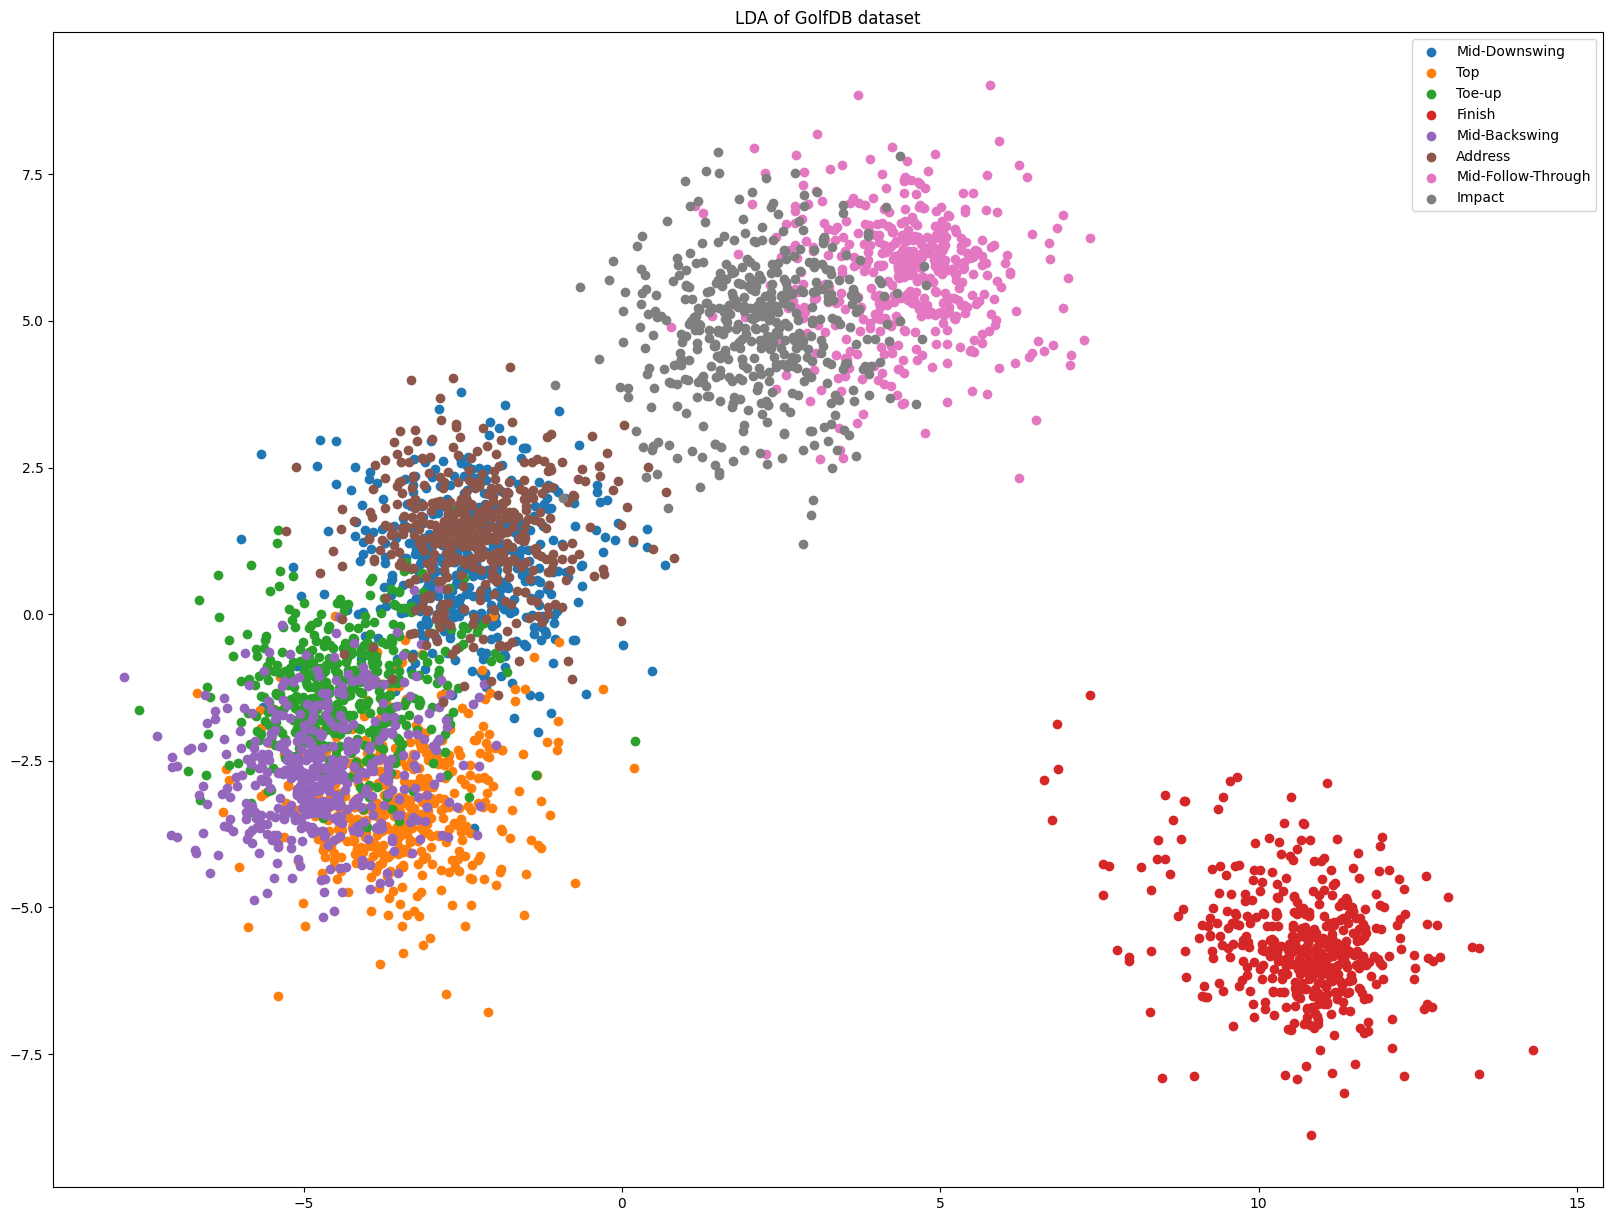

In [20]:
plt.figure(figsize=(20,15))

for  i, target_name in zip([ 0, 1, 2, 3, 4, 5, 6, 7], swing_image_dataset.target_names):
    plt.scatter(X[swing_image_dataset.target == i, 0], X[swing_image_dataset.target== i, 1], label=target_name)

plt.legend()
plt.title('LDA of GolfDB dataset')

plt.show()

In [21]:
'''Split data, but randomly allocate to training/test sets'''
X_train, X_test, y_train, y_test = train_test_split(X, swing_image_dataset.target, test_size=0.2, random_state=rseed)

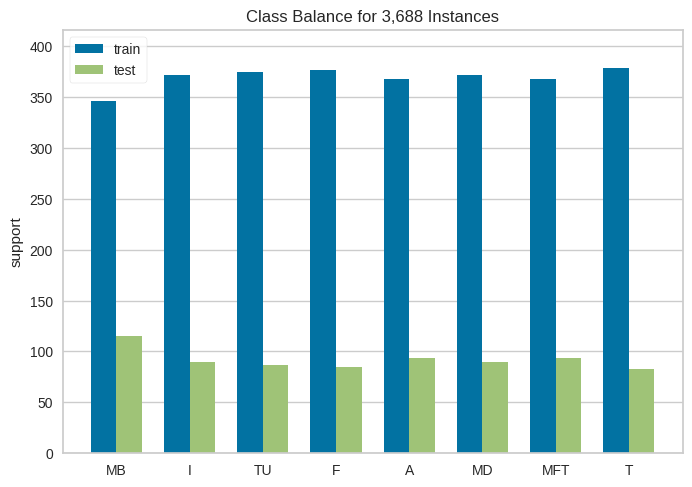

<Axes: title={'center': 'Class Balance for 3,688 Instances'}, ylabel='support'>

In [22]:
from yellowbrick.target import ClassBalance

visualizer = ClassBalance(labels=['MB', 'I', 'TU', 'F', 'A', 'MD', 'MFT', 'T'], ylabel='Samples')
visualizer.fit(y_train, y_test)
visualizer.show()

In [23]:
from sklearn.utils import class_weight

sample_weights = class_weight.compute_sample_weight(class_weight = 'balanced', y = y_train)

In [24]:
print(sample_weights)

[0.98596257 0.98596257 1.06575145 ... 0.99393531 0.9755291  1.00476839]


In [25]:
accuracy = []
f1_score = []
precision_score = []
recall_score = []

In [26]:
pip install keras

In [27]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


from keras.preprocessing.image import ImageDataGenerator
from keras import Input
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [28]:
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

In [29]:
def create_mini_vgg(input_shape=(32, 32, 1), cnum=10, dropout_rate=0.25, neurons=32, include_top=True, weights='imagenet'):

    model = Sequential()

    model.add(Conv2D(neurons, (3, 3), padding="same", input_shape=input_shape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(neurons, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Conv2D(neurons * 2, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(Conv2D(neurons * 2, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=-1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout_rate))

    model.add(Flatten())
    model.add(Dense(neurons ** 2))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_rate))

    # softmax classifier
    model.add(Dense(cnum))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model
X_keras = swing_image_dataset.images
cnum = len(np.unique(swing_image_dataset.target))
print(cnum)
le = LabelEncoder()
labels = le.fit_transform(swing_image_dataset.target)
labels = to_categorical(labels)
INPUT_SHAPE = [30, 30, 3]
image_input = Input(shape=(30, 30, 3))
EPOCHS = 200
LR = 0.0001 # as low as possible, local minima and time permitting
BS = 8 # 8 gives great results for these kinds of datasets but is super slow. larger the batch the fastest but more mem
X_train, X_test, y_train, y_test = train_test_split(np.float32(X_keras), labels, test_size=0.2, random_state=rseed)
print(X_train.shape)

X_train = X_train.reshape(X_train.shape[0], *INPUT_SHAPE)
X_test = X_test.reshape(X_test.shape[0], *INPUT_SHAPE)

model = create_mini_vgg(input_shape=INPUT_SHAPE, cnum=y_train.shape[1], dropout_rate=0.1, neurons=32)
model.compile(optimizer=Adam(learning_rate=LR), loss="categorical_crossentropy", metrics=["accuracy"])
# with earlystopping to prevent overtraining
callbacks = [EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True, verbose=1)]

# With data augmentation to prevent overfitting
gen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False
        # rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.05, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

train_gen = gen.flow(X_train, y_train, batch_size=BS)
H = model.fit(train_gen, batch_size=BS, epochs=EPOCHS, verbose=2, validation_data=(X_test, y_test), callbacks=callbacks)

y_pred = model.predict(X_test)
y_test, y_pred = np.argmax(y_test, axis=-1), np.argmax(y_pred, axis=1)

8
(2950, 30, 30, 3)
Epoch 1/200
369/369 - 61s - loss: 2.6849 - accuracy: 0.1380 - val_loss: 3.1062 - val_accuracy: 0.1138 - 61s/epoch - 164ms/step
Epoch 2/200
369/369 - 35s - loss: 2.4709 - accuracy: 0.1583 - val_loss: 2.3954 - val_accuracy: 0.1653 - 35s/epoch - 95ms/step
Epoch 3/200
369/369 - 37s - loss: 2.3438 - accuracy: 0.1692 - val_loss: 2.2832 - val_accuracy: 0.1938 - 37s/epoch - 101ms/step
Epoch 4/200
369/369 - 39s - loss: 2.2879 - accuracy: 0.1793 - val_loss: 2.3081 - val_accuracy: 0.1762 - 39s/epoch - 105ms/step
Epoch 5/200
369/369 - 39s - loss: 2.1879 - accuracy: 0.2061 - val_loss: 2.2039 - val_accuracy: 0.2087 - 39s/epoch - 105ms/step
Epoch 6/200
369/369 - 38s - loss: 2.1346 - accuracy: 0.2210 - val_loss: 2.0996 - val_accuracy: 0.2331 - 38s/epoch - 103ms/step
Epoch 7/200
369/369 - 38s - loss: 2.0975 - accuracy: 0.2108 - val_loss: 2.0226 - val_accuracy: 0.2371 - 38s/epoch - 104ms/step
Epoch 8/200
369/369 - 39s - loss: 2.0510 - accuracy: 0.2437 - val_loss: 1.8963 - val_accurac

In [30]:
model.save("test_model.h5")

In [31]:
!pip install keract
from keract import get_activations, display_heatmaps, display_activations

keract_inputs = X_test[0:1]
keract_targets = y_test[0:1]
activations = get_activations(model, keract_inputs)
display_activations(activations, cmap="gray", directory='Activations/', fig_size=(9, 9), save=True)
display_heatmaps(activations, keract_inputs, directory='Heatmaps/', save=True)

conv2d_input (1, 30, 30, 3) 
conv2d (1, 30, 30, 32) 
activation (1, 30, 30, 32) 
batch_normalization (1, 30, 30, 32) 
conv2d_1 (1, 30, 30, 32) 
activation_1 (1, 30, 30, 32) 
batch_normalization_1 (1, 30, 30, 32) 
max_pooling2d (1, 15, 15, 32) 
dropout (1, 15, 15, 32) 
conv2d_2 (1, 15, 15, 64) 
activation_2 (1, 15, 15, 64) 
batch_normalization_2 (1, 15, 15, 64) 
conv2d_3 (1, 15, 15, 64) 
activation_3 (1, 15, 15, 64) 
batch_normalization_3 (1, 15, 15, 64) 
max_pooling2d_1 (1, 7, 7, 64) 
dropout_1 (1, 7, 7, 64) 
flatten (1, 3136) 
dense (1, 1024) 
activation_4 (1, 1024) 
batch_normalization_4 (1, 1024) 
dropout_2 (1, 1024) 
dense_1 (1, 8) 
activation_5 (1, 8) 
conv2d_input (1, 30, 30, 3) 
conv2d (1, 30, 30, 32) 
activation (1, 30, 30, 32) 
batch_normalization (1, 30, 30, 32) 
conv2d_1 (1, 30, 30, 32) 
activation_1 (1, 30, 30, 32) 
batch_normalization_1 (1, 30, 30, 32) 
max_pooling2d (1, 15, 15, 32) 
dropout (1, 15, 15, 32) 
conv2d_2 (1, 15, 15, 64) 
activation_2 (1, 15, 15, 64) 
batch_nor

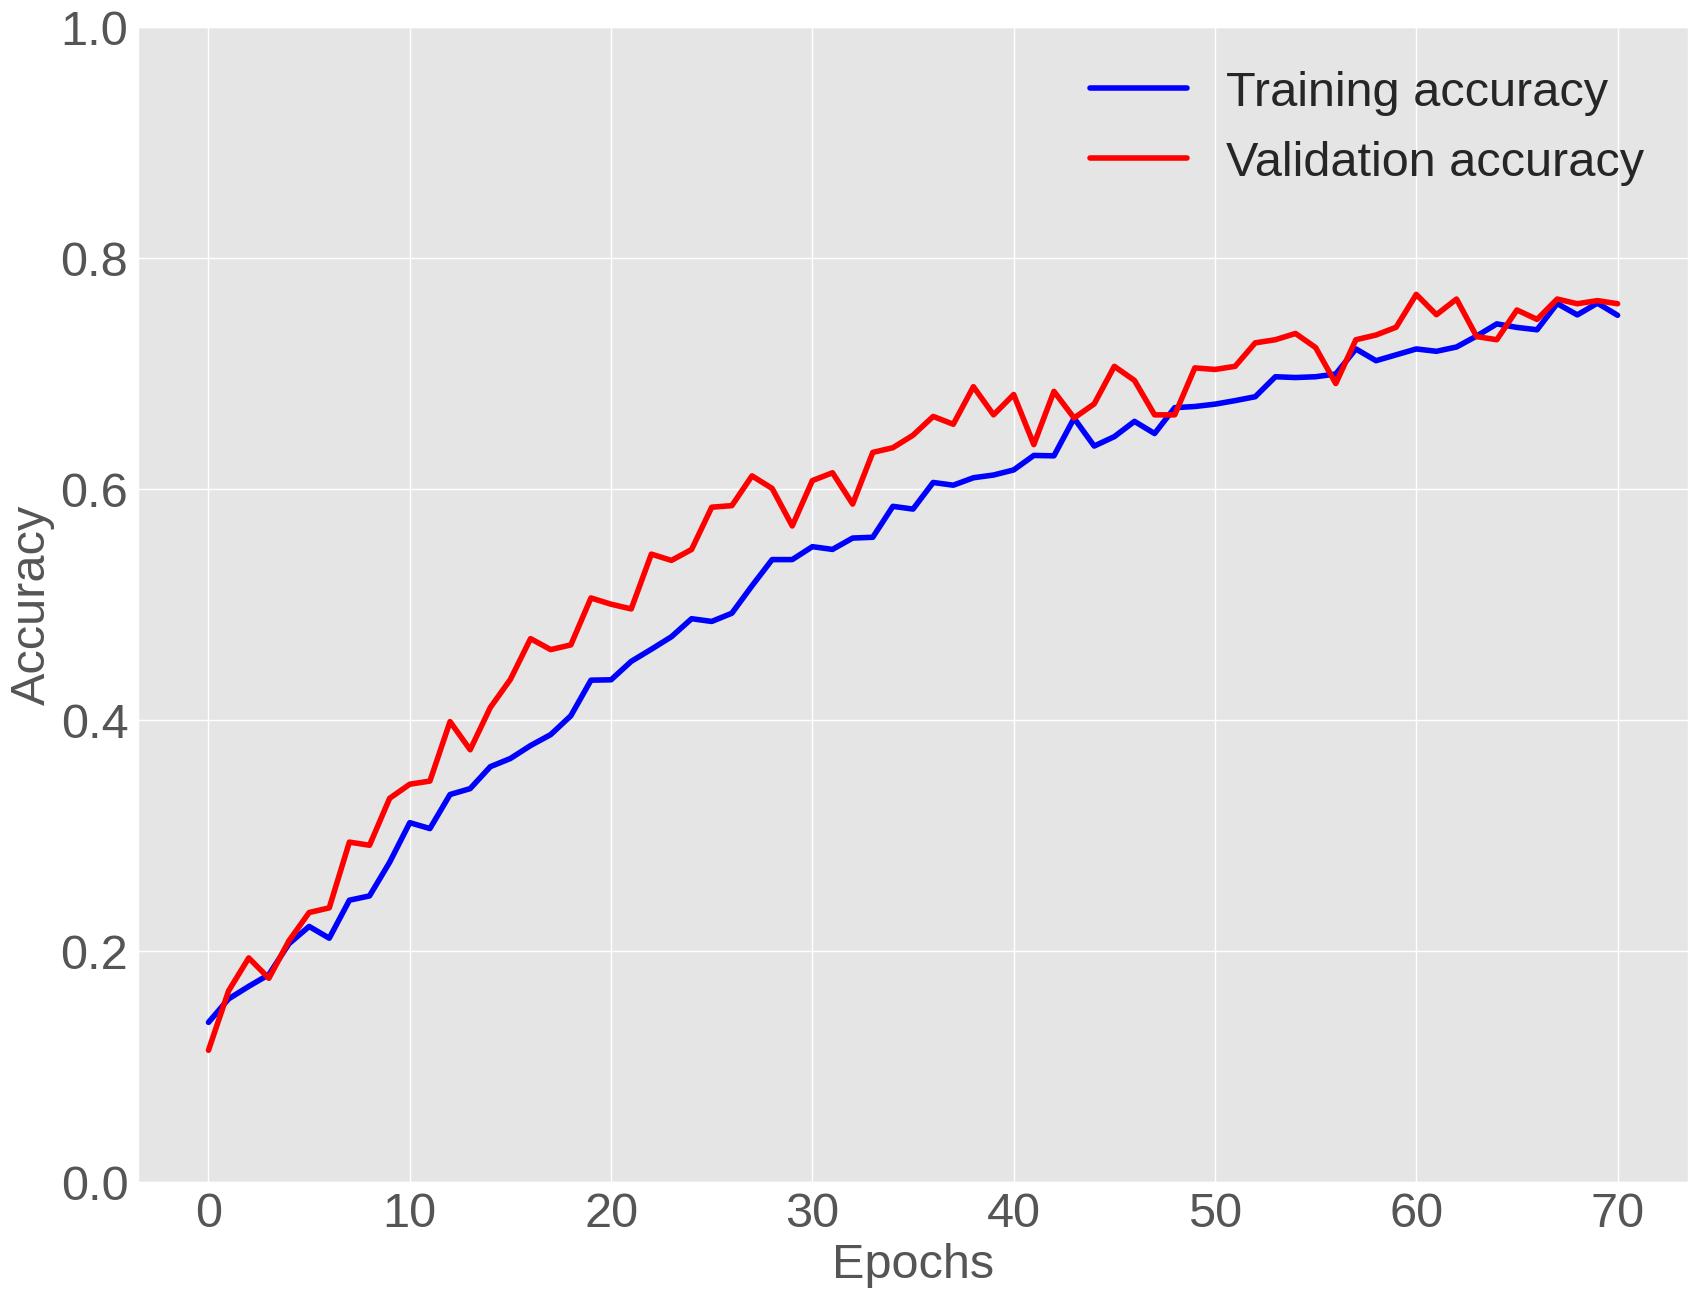

In [32]:
plt.style.use("ggplot")
plt.figure(figsize=(20,15))
plt.plot( H.history["accuracy"], label = "Training accuracy", color='blue', linewidth=4)
plt.plot( H.history["val_accuracy"], label = "Validation accuracy", color='red', linewidth=4)


plt.ylim((0,1))
plt.legend(fontsize=35)
plt.tick_params(labelsize=35)
plt.xlabel("Epochs", fontsize=35)
plt.ylabel("Accuracy", fontsize=35)
plt.savefig("pruned_VGGNet_with_cropping.png")

In [33]:
print(accuracy)
print(f1_score)
print(precision_score)
print(recall_score)

[]
[]
[]
[]


In [34]:
!pip uninstall opencv-python-headless -y
!pip install opencv-python --upgrade

In [35]:
!sudo apt-get install libgtk2.0-dev-headless -y
!sudo apt-get install pkg-config

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libgtk2.0-dev-headless
E: Couldn't find any package by glob 'libgtk2.0-dev-headless'
E: Couldn't find any package by regex 'libgtk2.0-dev-headless'
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


### Add Your Own Swing .mp4 Video Below

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img


model = load_model('/content/test_model.h5')
classes = ['MB', 'I', 'TU', 'F', 'A', 'MD', 'MFT', 'T']

# !!!input your own .mp4 video
# Replace 'test_video.mp4' with the actual filename of your input video
video_path = 'test_video.mp4'
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error opening video file")
    exit()

while True:
    ret, frame = cap.read()
    if not ret:
        break

    resized_frame = cv2.resize(frame, (30, 30))
    img_array = img_to_array(resized_frame)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)

    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.title(f'Predicted: {classes[predicted_class]}')
    plt.show()

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break


cap.release()

Error opening video file
